In [ ]:
#required libraries are imported here
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm
#divide the dataset to subsets
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# check for the  sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


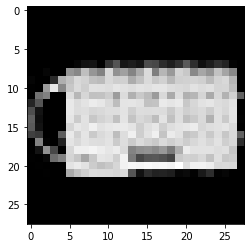

In [ ]:
# visualizing data
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [ ]:
# Define the network architecture
model = nn.Sequential(nn.Linear(784, 650),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(650, 420),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(420, 360),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(360, 230),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(230, 10),
                      nn.LogSoftmax(dim = 1)
                     )

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Define the epochs
epochs = 150
train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    #backward propagation
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    # Turn off gradients for validation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.4f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.4f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.4f}".format(accuracy/len(testloader)),
        )
    

Epoch: 1/150.. Training loss: 0.5688.. Test loss: 0.4453.. Test Accuracy: 0.8397
Epoch: 2/150.. Training loss: 0.4330.. Test loss: 0.4208.. Test Accuracy: 0.8485
Epoch: 3/150.. Training loss: 0.3947.. Test loss: 0.4125.. Test Accuracy: 0.8546
Epoch: 4/150.. Training loss: 0.3742.. Test loss: 0.3670.. Test Accuracy: 0.8695
Epoch: 5/150.. Training loss: 0.3556.. Test loss: 0.3765.. Test Accuracy: 0.8617
Epoch: 6/150.. Training loss: 0.3420.. Test loss: 0.3586.. Test Accuracy: 0.8723
Epoch: 7/150.. Training loss: 0.3318.. Test loss: 0.3600.. Test Accuracy: 0.8700
Epoch: 8/150.. Training loss: 0.3197.. Test loss: 0.3524.. Test Accuracy: 0.8736
Epoch: 9/150.. Training loss: 0.3115.. Test loss: 0.3802.. Test Accuracy: 0.8711
Epoch: 10/150.. Training loss: 0.3006.. Test loss: 0.3557.. Test Accuracy: 0.8705
Epoch: 11/150.. Training loss: 0.2996.. Test loss: 0.3443.. Test Accuracy: 0.8773
Epoch: 12/150.. Training loss: 0.2930.. Test loss: 0.3436.. Test Accuracy: 0.8824
Epoch: 13/150.. Training 

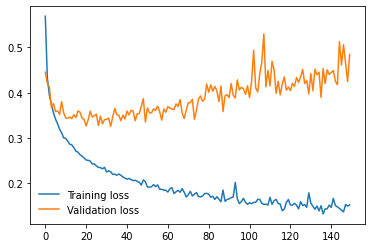

In [ ]:
#epochs => 25 accuracy => 0.8731
#epochs => 50 accuracy => 0.8760
#epochs => 70 accuracy => 0.8929
#epochs => 100 accuracy => 0.8972
#epochs ================> 0.8991 => 0.9002

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [ ]:
# looks like the loss value is increasing after some epochs

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

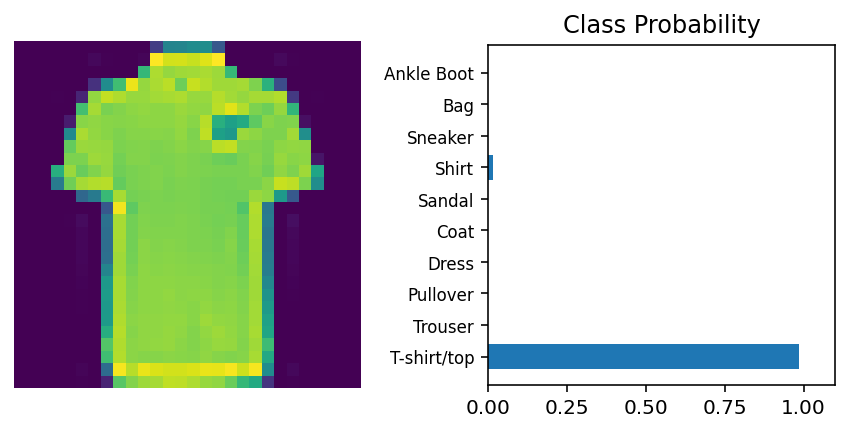

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Testing out the network
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.resize_(1, 784)
ps = torch.exp(model(img))
view_classify(img, ps, version='Fashion')

In [ ]:

print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Sequential(
  (0): Linear(in_features=784, out_features=650, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=650, out_features=420, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=420, out_features=360, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=360, out_features=230, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=230, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias', '12.weight', '12.bias'])
